# Lab 1

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\dot{a} \in A}e^{Q(s,\dot{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

# Respuestas 

A continuación se presentan las funciones presentadas en clases, modificadas para incorporar los algoritmos SARSA y Q-LEARNING, así como los métodos de exploración "greedy" y "softmax".

## Librerias requeridas

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Función de elección de acción

In [2]:
def choose_action(state, expl_method):
    """
    Elige una accion de acuerdo a lo aprendido según la politica de exploracino
    elegida: greedy o softmax
    """

    if expl_method == "greedy":

      q_values = [q.get((state, a), 0.0) for a in actions]
      max_q = max(q_values)

      if random_state.uniform() < epsilon:
          return random_state.choice(actions)  # a random action is selected

      count = q_values.count(max_q)

      # In case there're several state-action max values
      # we select a random one among them
      if count > 1:
          best = [i for i in range(len(actions)) if q_values[i] == max_q]
          i = random_state.choice(best)
      else:
          i = q_values.index(max_q)

      return actions[i]

    if expl_method == "softmax":
      action = 0
      div = []
      for i in range(0,4):
        div.append(np.exp(q.get((state, i), 0.0))/tau)
      div = sum(div)

      def get_prob(j): 
        prob = (np.exp(q.get((state,j), 0.0))/tau)/div
        return prob

      action = np.random.choice(actions, 1, p = [get_prob(0), get_prob(1), get_prob(2), get_prob(3)]) 

      return action.item()

## Función de aprendizaje

In [3]:
def learn(state, action, reward, next_state, next_action, method):
   
    # SARSA valor de q para el estado s y la accion a
    if method == "SARSA":
      q[(state,action)]= q.get((state, action),0.0) + alpha*(reward + (gamma*q.get((next_state,next_action),0.0) - q.get((state, action),0.0)))

    # Q-LEARNING
    if method == "QLEARNING":
      q_values = [q.get((next_state, a), 0.0) for a in actions]
      q[(state,action)]= q.get((state, action),0.0) + alpha*(reward + (gamma*max(q_values) - q.get((state, action),0.0)))

    pass

## Función de ejecución

In [4]:
def run(method, expl_method, a, g, e, t, seed):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    global q
    q = {}

    global env
    env = gym.make("CliffWalking-v0")
    
    global actions
    actions = range(env.action_space.n)

    global random_state
    random_state = np.random.RandomState(seed)

    global epsilon
    epsilon = e

    global alpha
    alpha = a

    global gamma
    gamma = g

    global tau
    tau = t
       
    episodes_to_run = 500
    
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state, expl_method)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state, expl_method)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action, method)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action, method)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode, q

## Funciones para graficar

In [5]:
def plot_reward_per_episode(reward_ep, title):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title(title)
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep, title):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title(title)
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep, title):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title(title)
    plt.show()
    

def draw_value_matrix(q, title):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.title(title)
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    #print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

# Análisis de convergencia de diferentes métodos e hiperparámetros

### Comparación entre los algoritmos SARSA y Q-LEARNING utilizando la estrategia de exploración *greedy*.

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep, q_1 = run(method = "SARSA", expl_method = "greedy", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)
avg_steps_per_episode2, timesteps_ep2, reward_ep2, q_2 = run(method = "QLEARNING", expl_method = "greedy", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)

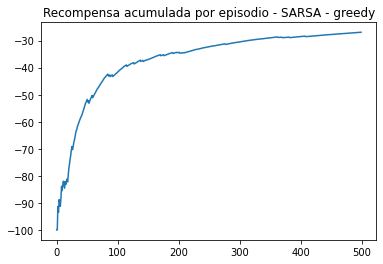

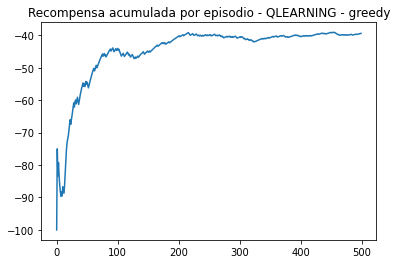

In [ ]:
plot_reward_per_episode(reward_ep, title = "Recompensa acumulada por episodio - SARSA - greedy")
plot_reward_per_episode(reward_ep2, title = "Recompensa acumulada por episodio - QLEARNING - greedy")

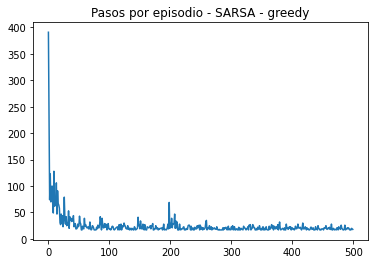

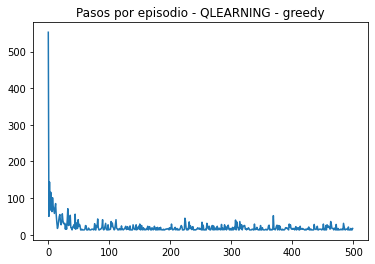

In [ ]:
plot_steps_per_episode(timesteps_ep, title = "Pasos por episodio - SARSA - greedy")
plot_steps_per_episode(timesteps_ep2, title = "Pasos por episodio - QLEARNING - greedy")

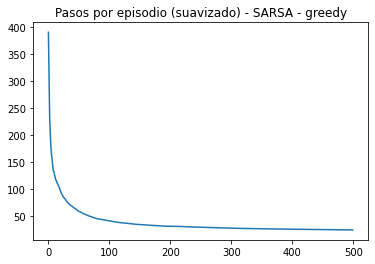

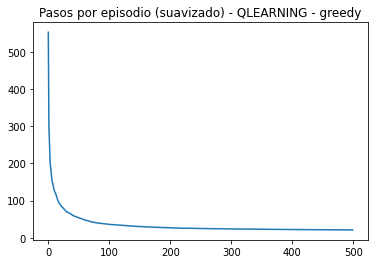

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep, title = "Pasos por episodio (suavizado) - SARSA - greedy")
plot_steps_per_episode_smooth(timesteps_ep2, title = "Pasos por episodio (suavizado) - QLEARNING - greedy")

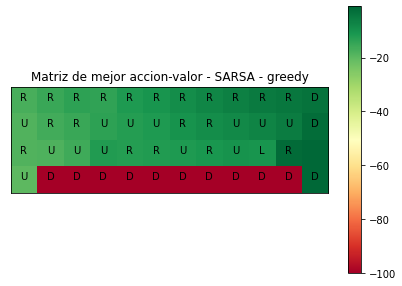

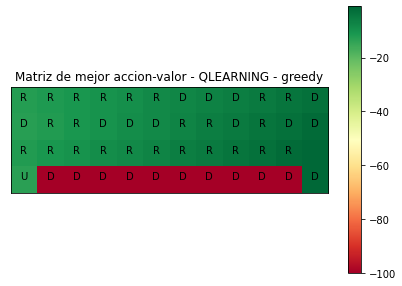

In [ ]:
draw_value_matrix(q_1, title = "Matriz de mejor accion-valor - SARSA - greedy")
draw_value_matrix(q_2, title = "Matriz de mejor accion-valor - QLEARNING - greedy")

La comparación entre los algoritmos SARSA y Q-LEARNING utilizando la estrategia de exploración greedy permite observar que el algoritmo SARSA tiene un mejor desempeño con dicha política de exploración. Este mejor desempeño se evidencia en que se obtiene una mayor recompensa acumulada (-30 vs -40). Así mismo, en el caso de SARSA el agente aprende a moverse más lejos del acantilado, mientras que Q-LEARNING ser aproxima a la política óptima.

### Comparación SARSA con política de exploración *greedy* y *softmax*.

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep, q_1 = run(method = "SARSA", expl_method = "greedy", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)
avg_steps_per_episode2, timesteps_ep2, reward_ep2, q_2 = run(method = "SARSA", expl_method = "softmax", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)

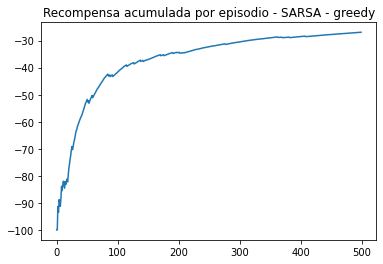

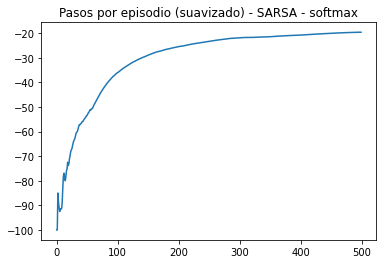

In [ ]:
plot_reward_per_episode(reward_ep, title = "Recompensa acumulada por episodio - SARSA - greedy")
plot_reward_per_episode(reward_ep2, title = "Pasos por episodio (suavizado) - SARSA - softmax")

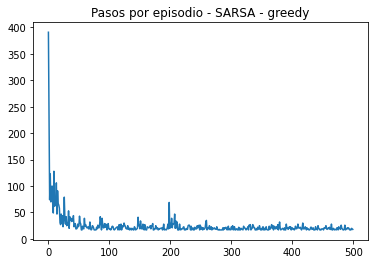

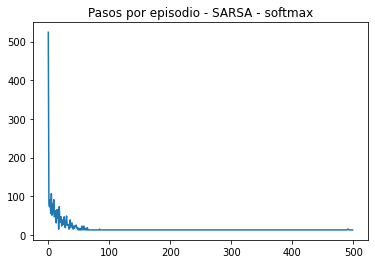

In [ ]:
plot_steps_per_episode(timesteps_ep, title = "Pasos por episodio - SARSA - greedy")
plot_steps_per_episode(timesteps_ep2, title = "Pasos por episodio - SARSA - softmax")

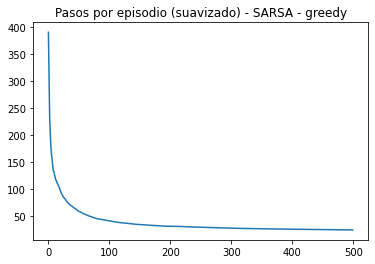

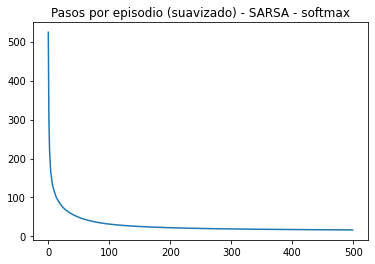

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep, title = "Pasos por episodio (suavizado) - SARSA - greedy")
plot_steps_per_episode_smooth(timesteps_ep2, title = "Pasos por episodio (suavizado) - SARSA - softmax")

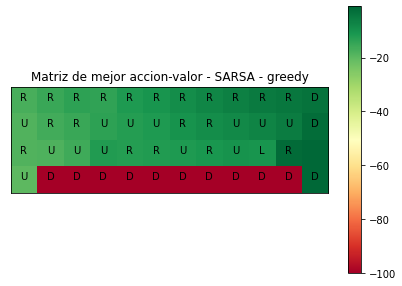

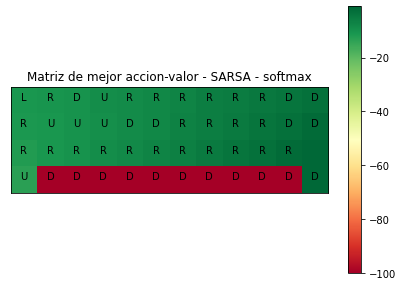

In [ ]:
draw_value_matrix(q_1, title = "Matriz de mejor accion-valor - SARSA - greedy")
draw_value_matrix(q_2, title = "Matriz de mejor accion-valor - SARSA - softmax")

La comparación entre las políticas de exploración greedy y softmax, en el algoritmo SARSA permite observar que el algoritmo SARSA tiene un mejor desempeño con la política de exploración *softmax*. Este mejor desempeño se evidencia en que se obtiene una mayor recompensa acumulada (-20 vs -30). Asimismo, similar a lo que sucede entre SARSA y Q-LEARNING con uin apolitica greedy, aquí el agente aprende a moverse más lejos del acantilado bajo la política *greedy*, mientras que se aproxima a la política óptima con *softmax*.

### Comparación de SARSA - softmax, variando hiperparámetros.

#### Comparación variando *alpha*

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep, q_1 = run(method = "SARSA", expl_method = "softmax", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)
avg_steps_per_episode2, timesteps_ep2, reward_ep2, q_2 = run(method = "SARSA", expl_method = "softmax", a = 0.05, g = 1, e = 0.1, t = 25, seed = 42)

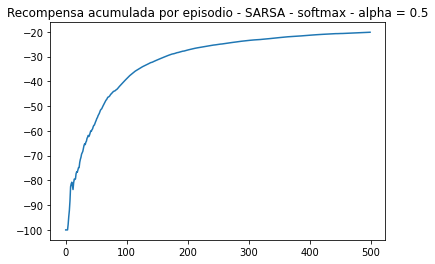

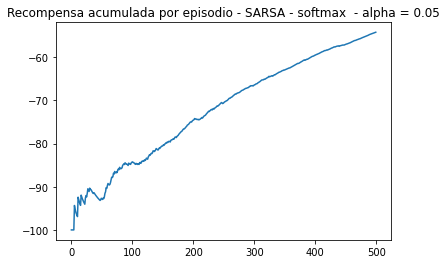

In [ ]:
plot_reward_per_episode(reward_ep, title = "Recompensa acumulada por episodio - SARSA - softmax - alpha = 0.5")
plot_reward_per_episode(reward_ep2, title = "Recompensa acumulada por episodio - SARSA - softmax  - alpha = 0.05")

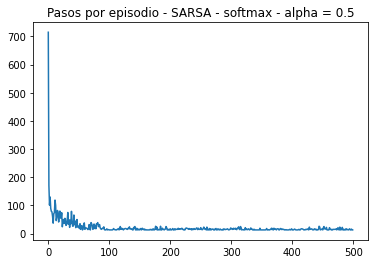

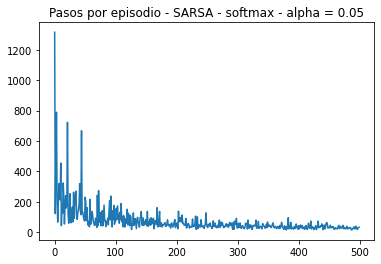

In [ ]:
plot_steps_per_episode(timesteps_ep, title = "Pasos por episodio - SARSA - softmax - alpha = 0.5")
plot_steps_per_episode(timesteps_ep2, title = "Pasos por episodio - SARSA - softmax - alpha = 0.05")

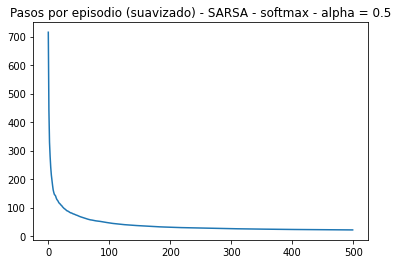

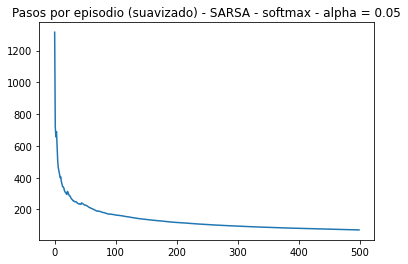

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep, title = "Pasos por episodio (suavizado) - SARSA - softmax - alpha = 0.5")
plot_steps_per_episode_smooth(timesteps_ep2, title = "Pasos por episodio (suavizado) - SARSA - softmax - alpha = 0.05")

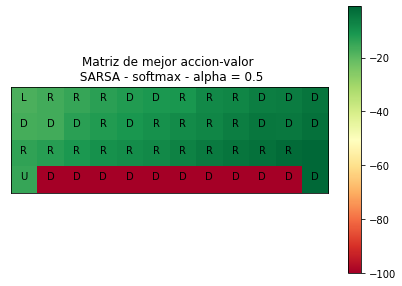

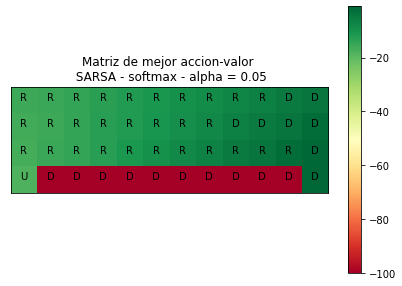

In [ ]:
draw_value_matrix(q_1, title = "Matriz de mejor accion-valor \n SARSA - softmax - alpha = 0.5")
draw_value_matrix(q_2, title = "Matriz de mejor accion-valor \n SARSA - softmax - alpha = 0.05")

Se observa que al dismunir la tasa de aprendizaje (*alpha*) el agente no logra converger, al menos dentro de los 500 episodios propuestos. Esto se debe a que la actualización de los valores de *q* se da en intervalos mas largos. Lo inverso sucedería si setearamos *alpha* en un valor alto (e.g. 0.9), donde la convergencia en de la recompensa acumulada debería alcanzarse en menos episodios (no mostrado).  

#### Comparación variando *gamma*

In [17]:
avg_steps_per_episode, timesteps_ep, reward_ep, q_1 = run(method = "SARSA", expl_method = "softmax", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)
avg_steps_per_episode2, timesteps_ep2, reward_ep2, q_2 = run(method = "SARSA", expl_method = "softmax", a = 0.5, g = 0.7, e = 0.1, t = 25, seed = 42)

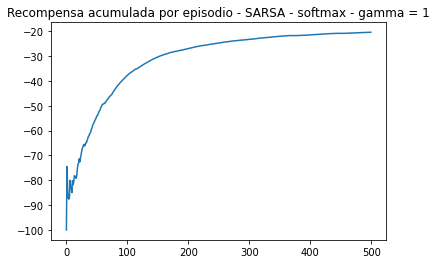

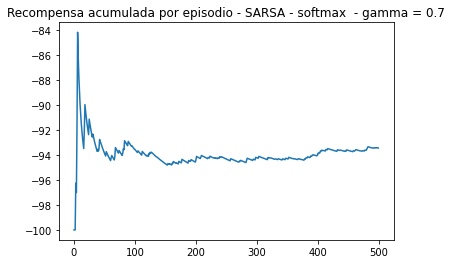

In [18]:
plot_reward_per_episode(reward_ep, title = "Recompensa acumulada por episodio - SARSA - softmax - gamma = 1")
plot_reward_per_episode(reward_ep2, title = "Recompensa acumulada por episodio - SARSA - softmax  - gamma = 0.7")

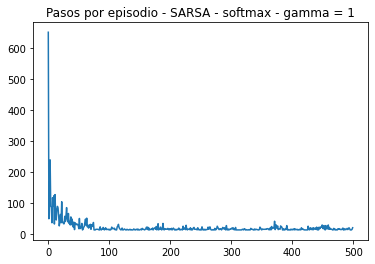

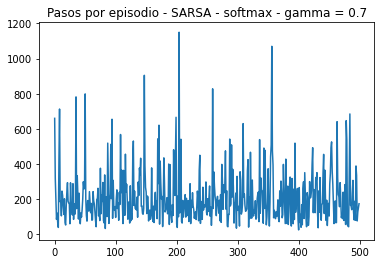

In [19]:
plot_steps_per_episode(timesteps_ep, title = "Pasos por episodio - SARSA - softmax - gamma = 1")
plot_steps_per_episode(timesteps_ep2, title = "Pasos por episodio - SARSA - softmax - gamma = 0.7")

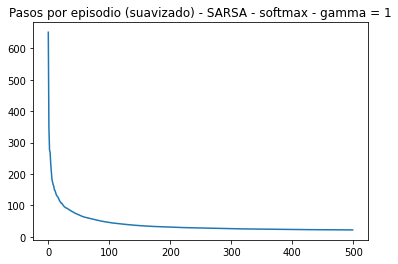

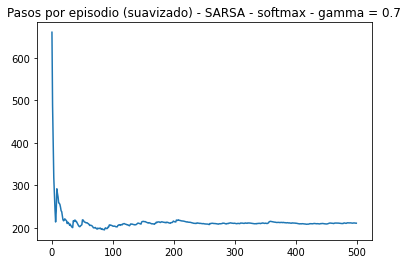

In [20]:
plot_steps_per_episode_smooth(timesteps_ep, title = "Pasos por episodio (suavizado) - SARSA - softmax - gamma = 1")
plot_steps_per_episode_smooth(timesteps_ep2, title = "Pasos por episodio (suavizado) - SARSA - softmax - gamma = 0.7")

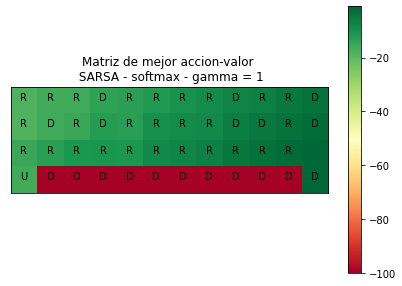

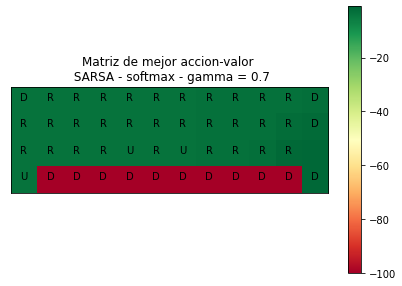

In [21]:
draw_value_matrix(q_1, title = "Matriz de mejor accion-valor \n SARSA - softmax - gamma = 1")
draw_value_matrix(q_2, title = "Matriz de mejor accion-valor \n SARSA - softmax - gamma = 0.7")

Se observa que al dismunir el factor de descuento  (*gamma*) el agente no logra converger adecuadamente, al menos dentro de los 500 episodios propuestos. Esto se debe a que en el caso dónde *gamma* = 1, no existe de hecho descuento, y el agente no es penalizado por cuantos episodios le requiere llegar a la meta. Dicho de otro modo, tiene mayor libertad para la exporación y logra aprender la política óptima en el contexto de un escenario determinista. Cuando se aplica el descuento, el agente debe considerar ahora si la recompensa inmediata es conveniente a una recompensa futura. Esto lleva a que en este escenario determinista, intente tomar la recompesa imediata en alguna ocasiones, no logrando así explorar el espacio de acciones que lo conducirían a la meta de forma óptima. De esta forma, el agente se estanca en cada episodio realizando pasos inconducentes que no le permiten acercarse a la meta en los sucesivos episodios (ver "Pasos por episodio suavizado").     

### Comparación de SARSA - greedy, variando hiperparámetros

#### Comparación variando *epsilon*

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep, q_1 = run(method = "SARSA", expl_method = "greedy", a = 0.5, g = 1, e = 0.1, t = 25, seed = 42)
avg_steps_per_episode2, timesteps_ep2, reward_ep2, q_2 = run(method = "SARSA", expl_method = "greedy", a = 0.5, g = 1, e = 0.0001, t = 25, seed = 42)

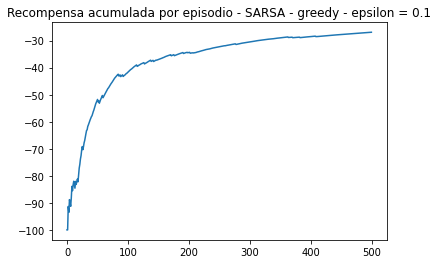

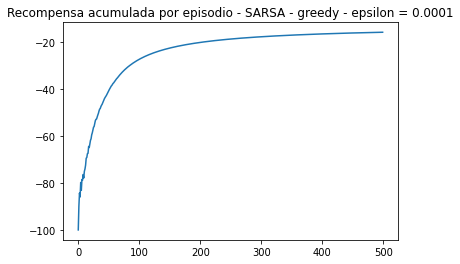

In [ ]:
plot_reward_per_episode(reward_ep, title = "Recompensa acumulada por episodio - SARSA - greedy - epsilon = 0.1")
plot_reward_per_episode(reward_ep2, title = "Recompensa acumulada por episodio - SARSA - greedy - epsilon = 0.0001")

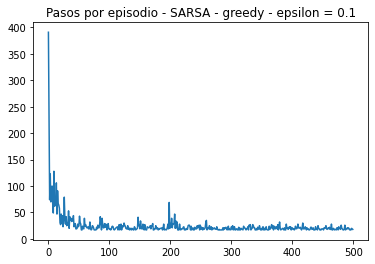

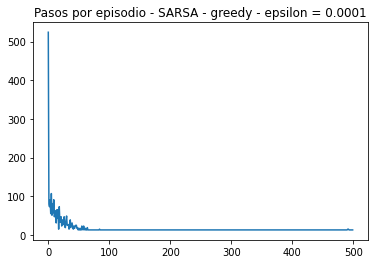

In [ ]:
plot_steps_per_episode(timesteps_ep, title = "Pasos por episodio - SARSA - greedy - epsilon = 0.1")
plot_steps_per_episode(timesteps_ep2, title = "Pasos por episodio - SARSA - greedy - epsilon = 0.0001")

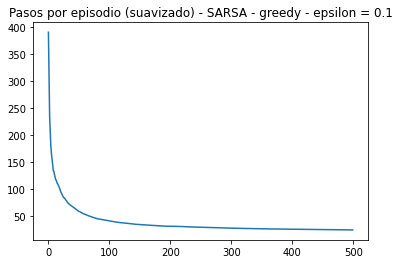

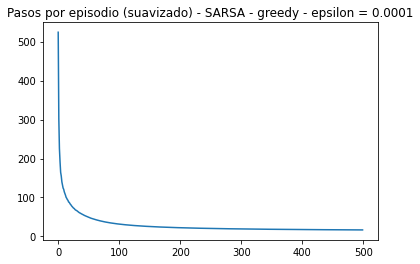

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep, title = "Pasos por episodio (suavizado) - SARSA - greedy - epsilon = 0.1")
plot_steps_per_episode_smooth(timesteps_ep2, title = "Pasos por episodio (suavizado) - SARSA - greedy - epsilon = 0.0001")

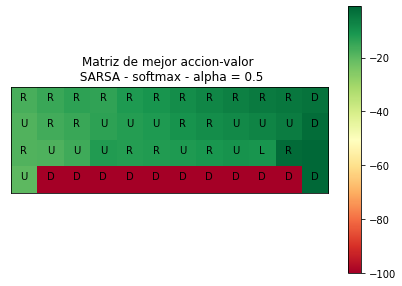

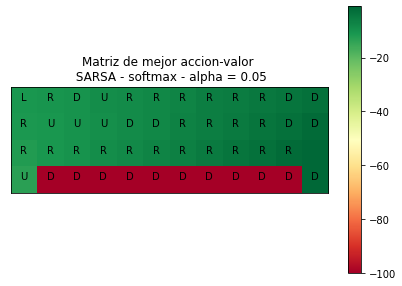

In [ ]:
draw_value_matrix(q_1, title = "Matriz de mejor accion-valor \n SARSA - softmax - alpha = 0.5")
draw_value_matrix(q_2, title = "Matriz de mejor accion-valor \n SARSA - softmax - alpha = 0.05")

Se observa que al dismunir *epsilon*, esto es la probabilidad de que el agente decida explorar respecto a tomar una decisión informada, resulta en una mejor perfomance en el escenario propuesto. El rendimiento del agente bajo esta condición se asemeja al comportamiento bajo la política softmax, donde el agente aprende un camino el camino más corto cercano al acantilado, maximizando así la reocompensa acumulada por episodio.